In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [4]:
def set_device():
    """
    Set the device to use for training and inference.
    """
    print(f"PyTorch version: {torch.__version__}")

    # Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")

    # Set the device
    if torch.backends.mps.is_available():
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    return device

def set_deterministic():
    """
    Set deterministic behavior for reproducibility.
    """
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    elif torch.backends.mps.is_available():
        # Currently, PyTorch-Metal (MPS backend) does not provide a direct way to set deterministic behavior.
        pass
    print("Set deterministic behavior")

In [5]:
set_deterministic()
device = set_device()

Set deterministic behavior
PyTorch version: 2.2.1+cu121
Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cuda


In [6]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])
len(train_data), len(test_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

(25000, 25000)

In [9]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [10]:
def tokenize(example, tokenizer, max_len):
    tokens = tokenizer(example["text"])[:max_len]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

def numericalize(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [11]:
max_len = 256
test_size = 0.25


train_data = train_data.map(lambda x: tokenize(x, tokenizer, max_len))
test_data = test_data.map(lambda x: tokenize(x, tokenizer, max_len))

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]
len(train_data), len(valid_data)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

(18750, 6250)

In [12]:
min_freq = 5 # Minimum frequency for words to be included in the vocabulary
specials = ["<unk>", "<pad>", "<bos>", "<eos>"]

vocab = torchtext.vocab.build_vocab_from_iterator(train_data["tokens"], min_freq=min_freq, specials=specials)

unk_index = vocab["<unk>"] # Unknown token for out-of-vocabulary words
pad_index = vocab["<pad>"] # Padding token
bos_index = vocab["<bos>"] # Beginning of sentence token
eos_index = vocab["<eos>"] # End of sentence token

vocab.set_default_index(unk_index)

In [13]:
train_data = train_data.map(lambda x: numericalize(x, vocab))
valid_data = valid_data.map(lambda x: numericalize(x, vocab))
test_data = test_data.map(lambda x: numericalize(x, vocab))

train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

train_data[0]

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

{'label': tensor(0),
 'length': tensor(256),
 'ids': tensor([   62,    14,   735,    10,   114,     4, 12526,     6,  1067,   159,
          3304,     0,     6,   750,     8,   593,   677,     6,    14,   196,
            13,   407,    11,    30,    37,    17,    82,    91,     4,    25,
            19,   496,    42, 18969,     0,     6,    43,    51,     7,  2462,
            23,  1751,  2768,   101,    24,    83,   100,  2768,   101,     5,
            83,     6,     4, 12526,    12,  3965,  4148, 16228,    20,    17,
           509,    10,    37,   179,  5832,     4,  8766,     6,     8,   952,
            39,   175,   721,     5,     4,   181,     9,     4,    25,    12,
            40,   354,     5,    57,   150,    78,    83,   353,    24,     4,
          1197,     8,     4,     0,     6,  5657,  6527,   181,     9,     4,
          1716,     8,  1199,    81,    32,     0,    22,    50,   169,    11,
            30,   109,   113,   316,  1532,     6,    70,    23,     7,   454,


In [16]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)

        batch_lengths = torch.tensor([i["length"] for i in batch])
        #batch_lenghts = torch.stack(batch_lengths)
        batch_labels = torch.tensor([i["label"] for i in batch])
        #batch_labels = torch.stack(batch_labels)

        batch = {"ids": batch_ids, "label": batch_labels, "length": batch_lengths}

        return batch

    return collate_fn


def get_data_loader(data, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset= data,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle = shuffle,
    )

    return data_loader

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [17]:
batch_size = 512

train_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_loader = get_data_loader(valid_data, batch_size, pad_index, shuffle=False)
test_loader = get_data_loader(test_data, batch_size, pad_index, shuffle=False)

batch = next(iter(train_loader))
batch["ids"].shape, batch["label"].shape, batch["length"].shape

(torch.Size([512, 256]), torch.Size([512]), torch.Size([512]))

In [18]:
batch['ids'][0], batch['label'][0], batch['length'][0]

(tensor([   14,   462,    10,    76,     4,    20,    91,     9,    44,  7178,
            15,     7,    25,  3326,     5,    13,   279,    11,    30,     7,
           541,  1236,    36,    42,     4,  3459,     5,     4,   658,    12,
           264,     8,    14,   222,   259,    17,    13,   103,    33,    89,
             7,    59,    20,    54,    13,    19,    15,   221,  1004,     5,
           893,     8,   117,    78,   346,    38,    38,    14,    74,     4,
           547,     9,   145,     7,    20,    75,    19,   100,     7,   709,
             9,  8478,     5,   266,     4,    20,   574, 12988,     6,    13,
           189,   424,     8,   424,     5,    14,   111,    16,    12,    44,
          4284,    20,    22,  1901,   115,     5,     5,    14,   138,   111,
            17,    13,    12,   309,   145,    21,    14,   698,    11,    30,
           112,   119, 16045,   934,  1407,     5,    94,    11,    30,   408,
           137,  1233,   315,   168,     6,   108,  

In [79]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, pad_index, bidrectional, dropout):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_index)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=bidrectional, dropout=dropout)

        self.fc = nn.Linear(hidden_size *  2 if bidrectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        self.initialize_weights()


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if "weight" in name:
                        nn.init.xavier_normal_(param)
                    elif "bias" in name:
                        nn.init.zeros_(param)


    def forward(self, ids, length):

        embedded = self.dropout(self.embedding(ids))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            #hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
        else:
            hidden = self.dropout(hidden[-1])
            hidden = hidden[-1]

        pred = self.fc(hidden)
        return pred

In [80]:
VOCAB_SIZE = len(vocab)
EMBED_SIZE = 300
HIDDEN_SIZE = 300
OUTPUT_SIZE = 2
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = LSTM(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, pad_index, BIDIRECTIONAL, DROPOUT)

In [81]:
print(model)
print(f"Model has {count_parameters(model):,} trainable parameters")

LSTM(
  (embedding): Embedding(21608, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Model has 10,093,202 trainable parameters


In [82]:
vectors = torchtext.vocab.FastText('simple')
pretrained_embeddings = vectors.get_vecs_by_tokens(vocab.get_itos(), lower_case_backup=True)
model.embedding.weight.data = pretrained_embeddings

In [87]:
LEARNING_RATE = 1e-3

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [76]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        length = batch["length"]

        optimizer.zero_grad()
        pred = model(ids, length)
        loss = criterion(pred, label)


        loss.backward()
        optimizer.step()

        acc = (pred.argmax(1) == label).sum().item() / len(label)
        #print(f"Trainin Acuuray: {acc}, Training Loss: {loss.item()}")

        epoch_losses.append(loss.item())
        epoch_accs.append(acc)

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [77]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            length = batch["length"]

            pred = model(ids, length)
            loss = criterion(pred, label)

            acc = (pred.argmax(1) == label).sum().item() / len(label)

            epoch_losses.append(loss.item())
            epoch_accs.append(acc)

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [84]:
N_EPOCHS = 10
best_valid_loss = float('inf')

metrics = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_loader, model, criterion, device)

    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_acc"].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch: {epoch+1}/{N_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")



100%|██████████| 13/13 [00:00<00:00, 20.64it/s]


Epoch: 1/10, Train Loss: 0.6444, Train Acc: 0.6187, Valid Loss: 0.5516, Valid Acc: 0.7258


100%|██████████| 13/13 [00:00<00:00, 21.01it/s]


Epoch: 2/10, Train Loss: 0.5526, Train Acc: 0.7214, Valid Loss: 0.5128, Valid Acc: 0.7529


100%|██████████| 13/13 [00:00<00:00, 21.06it/s]


Epoch: 3/10, Train Loss: 0.4401, Train Acc: 0.7990, Valid Loss: 0.4434, Valid Acc: 0.7872


100%|██████████| 13/13 [00:00<00:00, 20.24it/s]


Epoch: 4/10, Train Loss: 0.3897, Train Acc: 0.8256, Valid Loss: 0.4005, Valid Acc: 0.8168


100%|██████████| 13/13 [00:00<00:00, 20.27it/s]


Epoch: 5/10, Train Loss: 0.2961, Train Acc: 0.8771, Valid Loss: 0.3589, Valid Acc: 0.8598


100%|██████████| 13/13 [00:00<00:00, 19.83it/s]


Epoch: 6/10, Train Loss: 0.2698, Train Acc: 0.8915, Valid Loss: 0.5243, Valid Acc: 0.7793


100%|██████████| 13/13 [00:00<00:00, 20.42it/s]


Epoch: 7/10, Train Loss: 0.2341, Train Acc: 0.9047, Valid Loss: 0.3336, Valid Acc: 0.8530


100%|██████████| 13/13 [00:00<00:00, 19.39it/s]


Epoch: 8/10, Train Loss: 0.1996, Train Acc: 0.9210, Valid Loss: 0.3649, Valid Acc: 0.8633


100%|██████████| 13/13 [00:00<00:00, 20.10it/s]


Epoch: 9/10, Train Loss: 0.1602, Train Acc: 0.9385, Valid Loss: 0.4100, Valid Acc: 0.8738


100%|██████████| 13/13 [00:00<00:00, 19.88it/s]

Epoch: 10/10, Train Loss: 0.1390, Train Acc: 0.9474, Valid Loss: 0.3699, Valid Acc: 0.8736


## Plot Accuracy & Loss

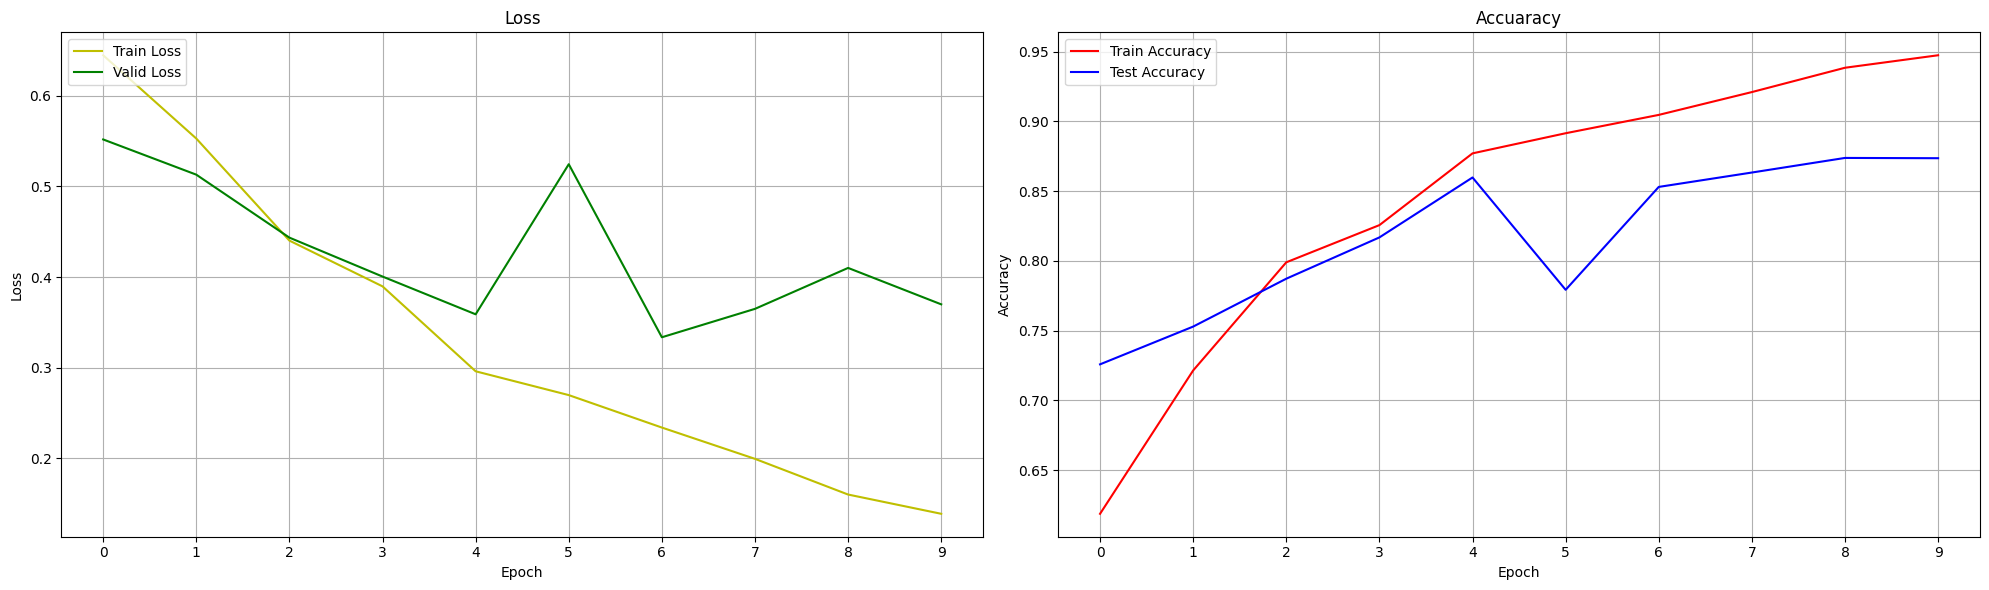

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # Two subplots in a row


ax1.plot(metrics["train_loss"], label="Train Loss", color='y')
ax1.plot(metrics["valid_loss"], label="Valid Loss", color='g')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.set_xticks(range(N_EPOCHS))
ax1.legend(loc='upper left')
ax1.grid(True)

# Second subplot for accuracy
ax2.plot(metrics["train_acc"], label="Train Accuracy", color='r')
ax2.plot(metrics["valid_acc"], label="Test Accuracy", color='b')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_xticks(range(N_EPOCHS))
ax2.set_title("Accuaracy")
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()


## Make Predicitons


In [69]:
def predict_sentiment(text, model, tokenizer, vocab, device):

  tokens = tokenizer(text)
  ids = vocab.lookup_indices(tokens)
  length = torch.LongTensor([len(ids)])
  tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)

  preds = model(tensor, length).squeeze(dim=0)
  probability = torch.softmax(preds, dim=-1)

  pred_class = preds.argmax(dim=-1).item()
  pred_probability = probability[pred_class].item()

  return f"Predicted Class: {pred_class}, Prediction Probability: {pred_probability}"

In [70]:
text = "This film is amazing"

predict_sentiment(text, model, tokenizer, vocab, device)

'Predicted Class: 1, Prediction Probability: 0.8777925968170166'